In [1]:
import math
import random as rd

from functools import reduce
from statistics import mean

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import ensemble, tree
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
# %matplotlib notebook

In [3]:
pd.options.display.max_columns = None

# Data

In [4]:
full_df = pd.read_csv('./data/bug_reports.csv')
full_df.iloc[:, :16]

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,FP,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,0,NO,3,hoursOffset accepts negative numbers between -...,1,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,0,NO,3,the conditional clause is correct for the give...,1,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,0,NO,3,The argument -2 is within the range (-23;23); ...,1,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,0,NO,3,The exception is in no way related to the hour...,1,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,0,NO,3,The issue cannot be with hoursOffset since the...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,0,NO,1,I don't believe this line would be the cause o...,1,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,1,YES,1,The line assumes that the string is a valid lo...,1,1
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,0,NO,1,This line is after all cases that throw the ex...,1,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,0,NO,1,The function never reaches this statement befo...,1,1


In [5]:
full_df = full_df.drop(labels = ['Answer.ID', 'Question.ID', 'TP', 'TN', 'FN', 'FP', 'Worker.ID'], axis = 'columns')

In [6]:
answer_option = full_df['Answer.option']
full_df['Answer.option'] = answer_option.map(lambda v: 1 if v == 'YES' else 0)
full_df

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage
0,HIT01_8,90.984,4,2,0,0,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#
1,HIT01_8,133.711,5,1,0,0,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#
2,HIT01_8,77.696,5,2,0,0,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP
3,HIT01_8,46.644,1,1,0,0,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#
4,HIT01_8,215.416,5,5,0,0,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,0,0,1,I don't believe this line would be the cause o...,1,1,3,Graduate_Student,2.0,28,Male,University,USA,C#
2576,HIT08_54,322.790,4,3,0,1,1,The line assumes that the string is a valid lo...,1,1,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java
2577,HIT08_54,159.530,5,1,0,0,1,This line is after all cases that throw the ex...,1,1,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++
2578,HIT08_54,68.578,5,1,0,0,1,The function never reaches this statement befo...,1,1,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++


In [7]:
worker_gender = full_df['Worker.gender']
full_df['Male'] = worker_gender.map(lambda v: v == 'Male')
full_df = full_df.drop(labels = ['Worker.gender'], axis = 'columns')
full_df

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male
0,HIT01_8,90.984,4,2,0,0,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True
1,HIT01_8,133.711,5,1,0,0,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False
2,HIT01_8,77.696,5,2,0,0,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,High School;University;Web,United States,C++;Java;PHP,True
3,HIT01_8,46.644,1,1,0,0,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,High School;University;Other On the job,USA,C#,True
4,HIT01_8,215.416,5,5,0,0,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,High School;University;Web,United States,C++; Java,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,0,0,1,I don't believe this line would be the cause o...,1,1,3,Graduate_Student,2.0,28,University,USA,C#,True
2576,HIT08_54,322.790,4,3,0,1,1,The line assumes that the string is a valid lo...,1,1,5,Professional_Developer,17.0,39,University;Web,USA,C#; VB.NET; Java,True
2577,HIT08_54,159.530,5,1,0,0,1,This line is after all cases that throw the ex...,1,1,4,Professional_Developer,10.0,31,High School;University;Web;Other work,usa,C++,True
2578,HIT08_54,68.578,5,1,0,0,1,The function never reaches this statement befo...,1,1,4,Undergraduate_Student,4.0,19,University;Web;Other FIRST Robotics,United States,C++,True


In [8]:
full_df['Answer.explanation'].unique()

array(['hoursOffset accepts negative numbers between -23 and 23. Which is what is stated it should accept.',
       'the conditional clause is correct for the given range of -23 to +23',
       'The argument -2 is within the range (-23;23); and therefore the if statement condition on line 276 will fail; causing the program to move to the next if statement.',
       ..., 'This line is after all cases that throw the exceptions.',
       'The function never reaches this statement before the error triggers',
       "No it's not an issue the the return calls Locale as function and it's properly fit."],
      dtype=object)

In [9]:
answer_explanation = full_df['Answer.explanation']
full_df['Answer.explanation_length'] = answer_explanation.map(lambda v: len(str(v)))
full_df

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male,Answer.explanation_length
0,HIT01_8,90.984,4,2,0,0,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True,98
1,HIT01_8,133.711,5,1,0,0,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False,67
2,HIT01_8,77.696,5,2,0,0,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,High School;University;Web,United States,C++;Java;PHP,True,163
3,HIT01_8,46.644,1,1,0,0,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,High School;University;Other On the job,USA,C#,True,64
4,HIT01_8,215.416,5,5,0,0,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,High School;University;Web,United States,C++; Java,True,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,0,0,1,I don't believe this line would be the cause o...,1,1,3,Graduate_Student,2.0,28,University,USA,C#,True,145
2576,HIT08_54,322.790,4,3,0,1,1,The line assumes that the string is a valid lo...,1,1,5,Professional_Developer,17.0,39,University;Web,USA,C#; VB.NET; Java,True,156
2577,HIT08_54,159.530,5,1,0,0,1,This line is after all cases that throw the ex...,1,1,4,Professional_Developer,10.0,31,High School;University;Web;Other work,usa,C++,True,55
2578,HIT08_54,68.578,5,1,0,0,1,The function never reaches this statement befo...,1,1,4,Undergraduate_Student,4.0,19,University;Web;Other FIRST Robotics,United States,C++,True,67


In [10]:
answer_explanation = full_df['Answer.explanation']
full_df['Answer.explanation_ttr'] = answer_explanation.map(lambda v: len(set(str(v).split())) / len(str(v).split()))
full_df

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male,Answer.explanation_length,Answer.explanation_ttr
0,HIT01_8,90.984,4,2,0,0,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True,98,0.937500
1,HIT01_8,133.711,5,1,0,0,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False,67,0.923077
2,HIT01_8,77.696,5,2,0,0,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,High School;University;Web,United States,C++;Java;PHP,True,163,0.827586
3,HIT01_8,46.644,1,1,0,0,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,High School;University;Other On the job,USA,C#,True,64,1.000000
4,HIT01_8,215.416,5,5,0,0,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,High School;University;Web,United States,C++; Java,True,100,0.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,0,0,1,I don't believe this line would be the cause o...,1,1,3,Graduate_Student,2.0,28,University,USA,C#,True,145,0.766667
2576,HIT08_54,322.790,4,3,0,1,1,The line assumes that the string is a valid lo...,1,1,5,Professional_Developer,17.0,39,University;Web,USA,C#; VB.NET; Java,True,156,0.928571
2577,HIT08_54,159.530,5,1,0,0,1,This line is after all cases that throw the ex...,1,1,4,Professional_Developer,10.0,31,High School;University;Web;Other work,usa,C++,True,55,1.000000
2578,HIT08_54,68.578,5,1,0,0,1,The function never reaches this statement befo...,1,1,4,Undergraduate_Student,4.0,19,University;Web;Other FIRST Robotics,United States,C++,True,67,1.000000


In [11]:
full_df['Correct'] = full_df['Answer.option'] == full_df['GroundTruth']
full_df = full_df.drop(labels = ['Answer.option', 'GroundTruth'], axis = 'columns')
full_df

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male,Answer.explanation_length,Answer.explanation_ttr,Correct
0,HIT01_8,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True,98,0.937500,True
1,HIT01_8,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False,67,0.923077,True
2,HIT01_8,77.696,5,2,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,High School;University;Web,United States,C++;Java;PHP,True,163,0.827586,True
3,HIT01_8,46.644,1,1,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,High School;University;Other On the job,USA,C#,True,64,1.000000,True
4,HIT01_8,215.416,5,5,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,High School;University;Web,United States,C++; Java,True,100,0.941176,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,1,I don't believe this line would be the cause o...,1,1,3,Graduate_Student,2.0,28,University,USA,C#,True,145,0.766667,True
2576,HIT08_54,322.790,4,3,1,The line assumes that the string is a valid lo...,1,1,5,Professional_Developer,17.0,39,University;Web,USA,C#; VB.NET; Java,True,156,0.928571,False
2577,HIT08_54,159.530,5,1,1,This line is after all cases that throw the ex...,1,1,4,Professional_Developer,10.0,31,High School;University;Web;Other work,usa,C++,True,55,1.000000,True
2578,HIT08_54,68.578,5,1,1,The function never reaches this statement befo...,1,1,4,Undergraduate_Student,4.0,19,University;Web;Other FIRST Robotics,United States,C++,True,67,1.000000,True


In [12]:
holdout_failing_method_idxs = sorted(rd.sample(range(6), k = 2))
holdout_failing_method_idxs

[4, 5]

In [13]:
holdout_failing_methods = full_df['FailingMethod'].unique()[holdout_failing_method_idxs]
holdout_failing_methods

array(['HIT05_35', 'HIT06_51'], dtype=object)

In [14]:
train_failing_methods = np.delete(full_df['FailingMethod'].unique(), holdout_failing_method_idxs)
train_failing_methods

array(['HIT01_8', 'HIT02_24', 'HIT03_6', 'HIT04_7', 'HIT07_33',
       'HIT08_54'], dtype=object)

In [15]:
full_df['FailingMethod'].describe()

count        2580
unique          8
top       HIT04_7
freq          740
Name: FailingMethod, dtype: object

In [16]:
failing_method_dummies = pd.get_dummies(full_df['FailingMethod'])
failing_method_dummies

,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54
0,True,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2575,False,False,False,False,False,False,False,True
2576,False,False,False,False,False,False,False,True
2577,False,False,False,False,False,False,False,True
2578,False,False,False,False,False,False,False,True


In [17]:
full_df['Worker.profession'].describe()

count                       2580
unique                         5
top       Professional_Developer
freq                         983
Name: Worker.profession, dtype: object

In [18]:
worker_profession_dummies = pd.get_dummies(full_df['Worker.profession'])
worker_profession_dummies = worker_profession_dummies.rename(columns={'Other': 'Other profession'})
worker_profession_dummies

,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,False,True
...,...,...,...,...,...
2575,True,False,False,False,False
2576,False,False,False,True,False
2577,False,False,False,True,False
2578,False,False,False,False,True


In [19]:
full_df['Worker.country'].describe()

count     2580
unique      36
top        USA
freq      1021
Name: Worker.country, dtype: object

In [20]:
worker_country_dummies = pd.get_dummies(full_df['Worker.country'])
worker_country_dummies

,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2577,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2578,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [21]:
full_df['Worker.whereLearnedToCode'].describe()

count           2580
unique            63
top       University
freq             821
Name: Worker.whereLearnedToCode, dtype: object

In [22]:
where_learned_to_code = reduce(lambda acc, s: acc | set(s.lower().strip().split(';')), full_df['Worker.whereLearnedToCode'], set())
where_learned_to_code

{' books',
 ' no?',
 ' there was no "internet". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept',
 'high school',
 'other',
 'other as long as i can remember honestly',
 'other at work',
 'other autodidact',
 'other books',
 'other by myself from books',
 'other diploma',
 'other elementary school',
 'other employer',
 'other first robotics',
 'other forever',
 'other found a book',
 'other had a book on basic when i was a kid',
 'other hobby',
 'other hobbyist',
 'other i really dont remember a time when i couldnt',
 'other instructional books',
 'other java while on the job',
 'other junior high computer class',
 'other leanred more experts at work',
 'other middle school',
 'other mooc',
 'other na',
 'other on the job',
 'other private',
 'other private institute',
 'other professional',
 'other professionally',
 'other self help books',
 'other self study',
 'other self taught',
 'other self-study',
 'other self-taught',
 'other self-taught as a chi

In [23]:
# full_df['Worker.whereLearnedToCode'].str.lower().str.strip().str.contains(attr)

In [24]:
for attr in where_learned_to_code:
    verbose_attr = attr.strip().capitalize()
    full_df[verbose_attr] = full_df['Worker.whereLearnedToCode'].str.lower().str.strip().str.contains(attr)
full_df

/tmp/ipykernel_6936/1561382675.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  full_df[verbose_attr] = full_df['Worker.whereLearnedToCode'].str.lower().str.strip().str.contains(attr)


,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male,Answer.explanation_length,Answer.explanation_ttr,Correct,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private
0,HIT01_8,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True,98,0.937500,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,HIT01_8,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False,67,0.923077,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,HIT01_8,77.696,5,2,3,The argument -2 is within the range (-23;23); ...,1,1,5,Professional_Developer,7.0,24,High School;University;Web,United States,C++;Java;PHP,True,163,0.827586,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,HIT01_8,46.644,1,1,3,The exception is in no way related to the hour...,1,1,5,Professional_Developer,20.0,38,High School;University;Other On the job,USA,C#,True,64,1.000000,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False
4,HIT01_8,215.416,5,5,3,The issue cannot be with hoursOffset since the...,1,1,3,Undergraduate_Student,5.0,19,High School;University;Web,United States,C++; Java,True,100,0.941176,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,HIT08_54,220.420,2,4,1,I don't believe this line would be the cause o...,1,1,

In [25]:
full_df['Worker.programmingLanguage'].describe()

count     2568
unique     176
top       Java
freq       315
Name: Worker.programmingLanguage, dtype: object

In [26]:
programming_languages = reduce(lambda acc, s: acc | set(str(s).lower().strip().split(';')), full_df['Worker.programmingLanguage'], set())
programming_languages

{'',
 ' .net',
 ' a little bit of java',
 ' ahk',
 ' asp',
 ' asp.net',
 ' assembly',
 ' autoit',
 ' c',
 ' c ',
 ' c#',
 ' c+',
 ' c++',
 ' c/c++',
 ' css',
 ' css3',
 ' cuda',
 ' elixir',
 ' go',
 ' groovy',
 ' html',
 ' html5',
 ' java',
 ' javascript',
 ' jee',
 ' js',
 ' matlab',
 ' most c and ksh in past',
 ' mql4',
 ' mysql',
 ' peoplesoft',
 ' perl',
 ' php',
 ' pl/sql',
 ' plsql',
 ' python',
 ' r',
 ' ruby',
 ' ruby on rails',
 ' scala',
 ' scheme',
 ' sql',
 ' vb.net',
 ' vba',
 ' vbscript',
 ' vhdl',
 ' visual basic',
 '.net',
 '3',
 '5',
 '6',
 'ada',
 'ajax',
 'asp.net',
 'bash',
 'bash and powershell',
 'basic',
 'c',
 'c sharp',
 'c#',
 'c# vb.net java',
 'c++',
 'c++ and python',
 'c/c++',
 'c/c++ and some python and java',
 'developing',
 'do not currently use',
 'dot net and core java',
 'euphoria',
 'html',
 'html/css (formerly c# and java in previous jobs)',
 'jav',
 'java',
 'java ',
 'java c++',
 'java python',
 'javascript',
 'jsp',
 'magic',
 'matlab',
 'mysql'

In [27]:
full_df['Worker.programmingLanguage'].str.lower().str.strip().str.contains(attr)

0       False
1       False
2       False
3       False
4       False
        ...  
2575    False
2576    False
2577    False
2578    False
2579    False
Name: Worker.programmingLanguage, Length: 2580, dtype: object

In [28]:
for attr in programming_languages:
    verbose_attr = attr.strip().capitalize()
    full_df[verbose_attr] = full_df['Worker.programmingLanguage'].str.lower().str.strip().str.contains(attr)
full_df

/tmp/ipykernel_6936/1858395325.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  full_df[verbose_attr] = full_df['Worker.programmingLanguage'].str.lower().str.strip().str.contains(attr)
/tmp/ipykernel_6936/1858395325.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  full_df[verbose_attr] = full_df['Worker.programmingLanguage'].str.lower().str.strip().str.contains(attr)
/tmp/ipykernel_6936/1858395325.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df[verbose_attr] = full_df['Worker.programmingLanguage'].str.lower().str.strip().str.contains(attr)
/tmp/ipykernel_6936/18583

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,Male,Answer.explanation_length,Answer.explanation_ttr,Correct,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use
0,HIT01_8,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,Undergraduate_Student,7.0,21,High School,United States,Java; C++; C#,True,98,0.937500,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,HIT01_8,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,Undergraduate_Student,10.0,25,High School;University;Web,United States,c#,False,67,0.923077,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [29]:
full_df = full_df.join(failing_method_dummies)
full_df = full_df.join(worker_profession_dummies)
full_df = full_df.join(worker_country_dummies)
full_df = full_df.drop(
    labels = ['FailingMethod', 'Worker.profession', 'Worker.country', 'Worker.whereLearnedToCode', 'Worker.programmingLanguage'],
    axis = 'columns'
)
full_df

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Correct,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa
0,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,7.0,21,True,98,0.937500,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,10.0,25,False,67,0.923077,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,

In [30]:
full_df = full_df = full_df.drop(labels = ['Correct'], axis = 'columns').join(full_df['Correct'])
full_df

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa,Correct
0,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,7.0,21,True,98,0.937500,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,10.0,25,False,67,0.923077,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False

In [31]:
holdout_df = full_df[full_df[holdout_failing_methods[0]] | full_df[holdout_failing_methods[1]]]
holdout_df = holdout_df.drop(labels = ['Answer.explanation'], axis = 'columns')
holdout_df

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa,Correct
1400,97.788,5,3,3,1,1,3,10.0,27,False,242,0.818182,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1401,54.289,4,2,3,1,1,3,5.0,20,True,106,0.863636,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,Tr

In [32]:
train_df = full_df[~(full_df[holdout_failing_methods[0]] | full_df[holdout_failing_methods[1]])]
train_df = train_df.drop(labels = ['Answer.explanation'], axis = 'columns')
train_df

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa,Correct
0,90.984,4,2,3,1,1,5,7.0,21,True,98,0.937500,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,133.711,5,1,3,1,1,4,10.0,25,False,67,0.923077,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False

# Training

In [33]:
cfl = tree.DecisionTreeClassifier()

In [34]:
cfl_forest = ensemble.RandomForestClassifier()

In [35]:
param_grid = [
  {
      'max_depth': [1, 5, 10, 20, 50],
      'min_samples_split': [2, 4, 6, 8, 10],
      'min_samples_leaf': [1, 2, 4, 6, 8, 10],
      'max_features': [2, 4, 8, 12, 16],
      'n_estimators': [1, 10, 20, 50, 100],
  },
]

In [36]:
prec = make_scorer(precision_score, zero_division = 0)
grid_search = GridSearchCV(
    estimator = cfl_forest,
    param_grid = param_grid,
    scoring = {'precision': prec, 'recall': 'recall', 'f1': 'f1'},
    refit = 'f1',
    cv = 5,
    verbose = 1
)

In [37]:
X = train_df.iloc[:, :-1]
X

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa
0,90.984,4,2,3,1,1,5,7.0,21,True,98,0.937500,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,133.711,5,1,3,1,1,4,10.0,25,False,67,0.923077,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [38]:
y = train_df.iloc[:, -1]
y

0        True
1        True
2        True
3        True
4        True
        ...  
2575     True
2576    False
2577     True
2578     True
2579     True
Name: Correct, Length: 2040, dtype: bool

In [39]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3750 candidates, totalling 18750 fits


/home/necrox/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [1, 5, 10, 20, 50],
                          'max_features': [2, 4, 8, 12, 16],
                          'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                          'min_samples_split': [2, 4, 6, 8, 10],
                          'n_estimators': [1, 10, 20, 50, 100]}],
             refit='f1',
             scoring={'f1': 'f1',
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': 'recall'},
             verbose=1)

In [40]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [41]:
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(max_depth=20, max_features=16, min_samples_leaf=2,
                       n_estimators=50)

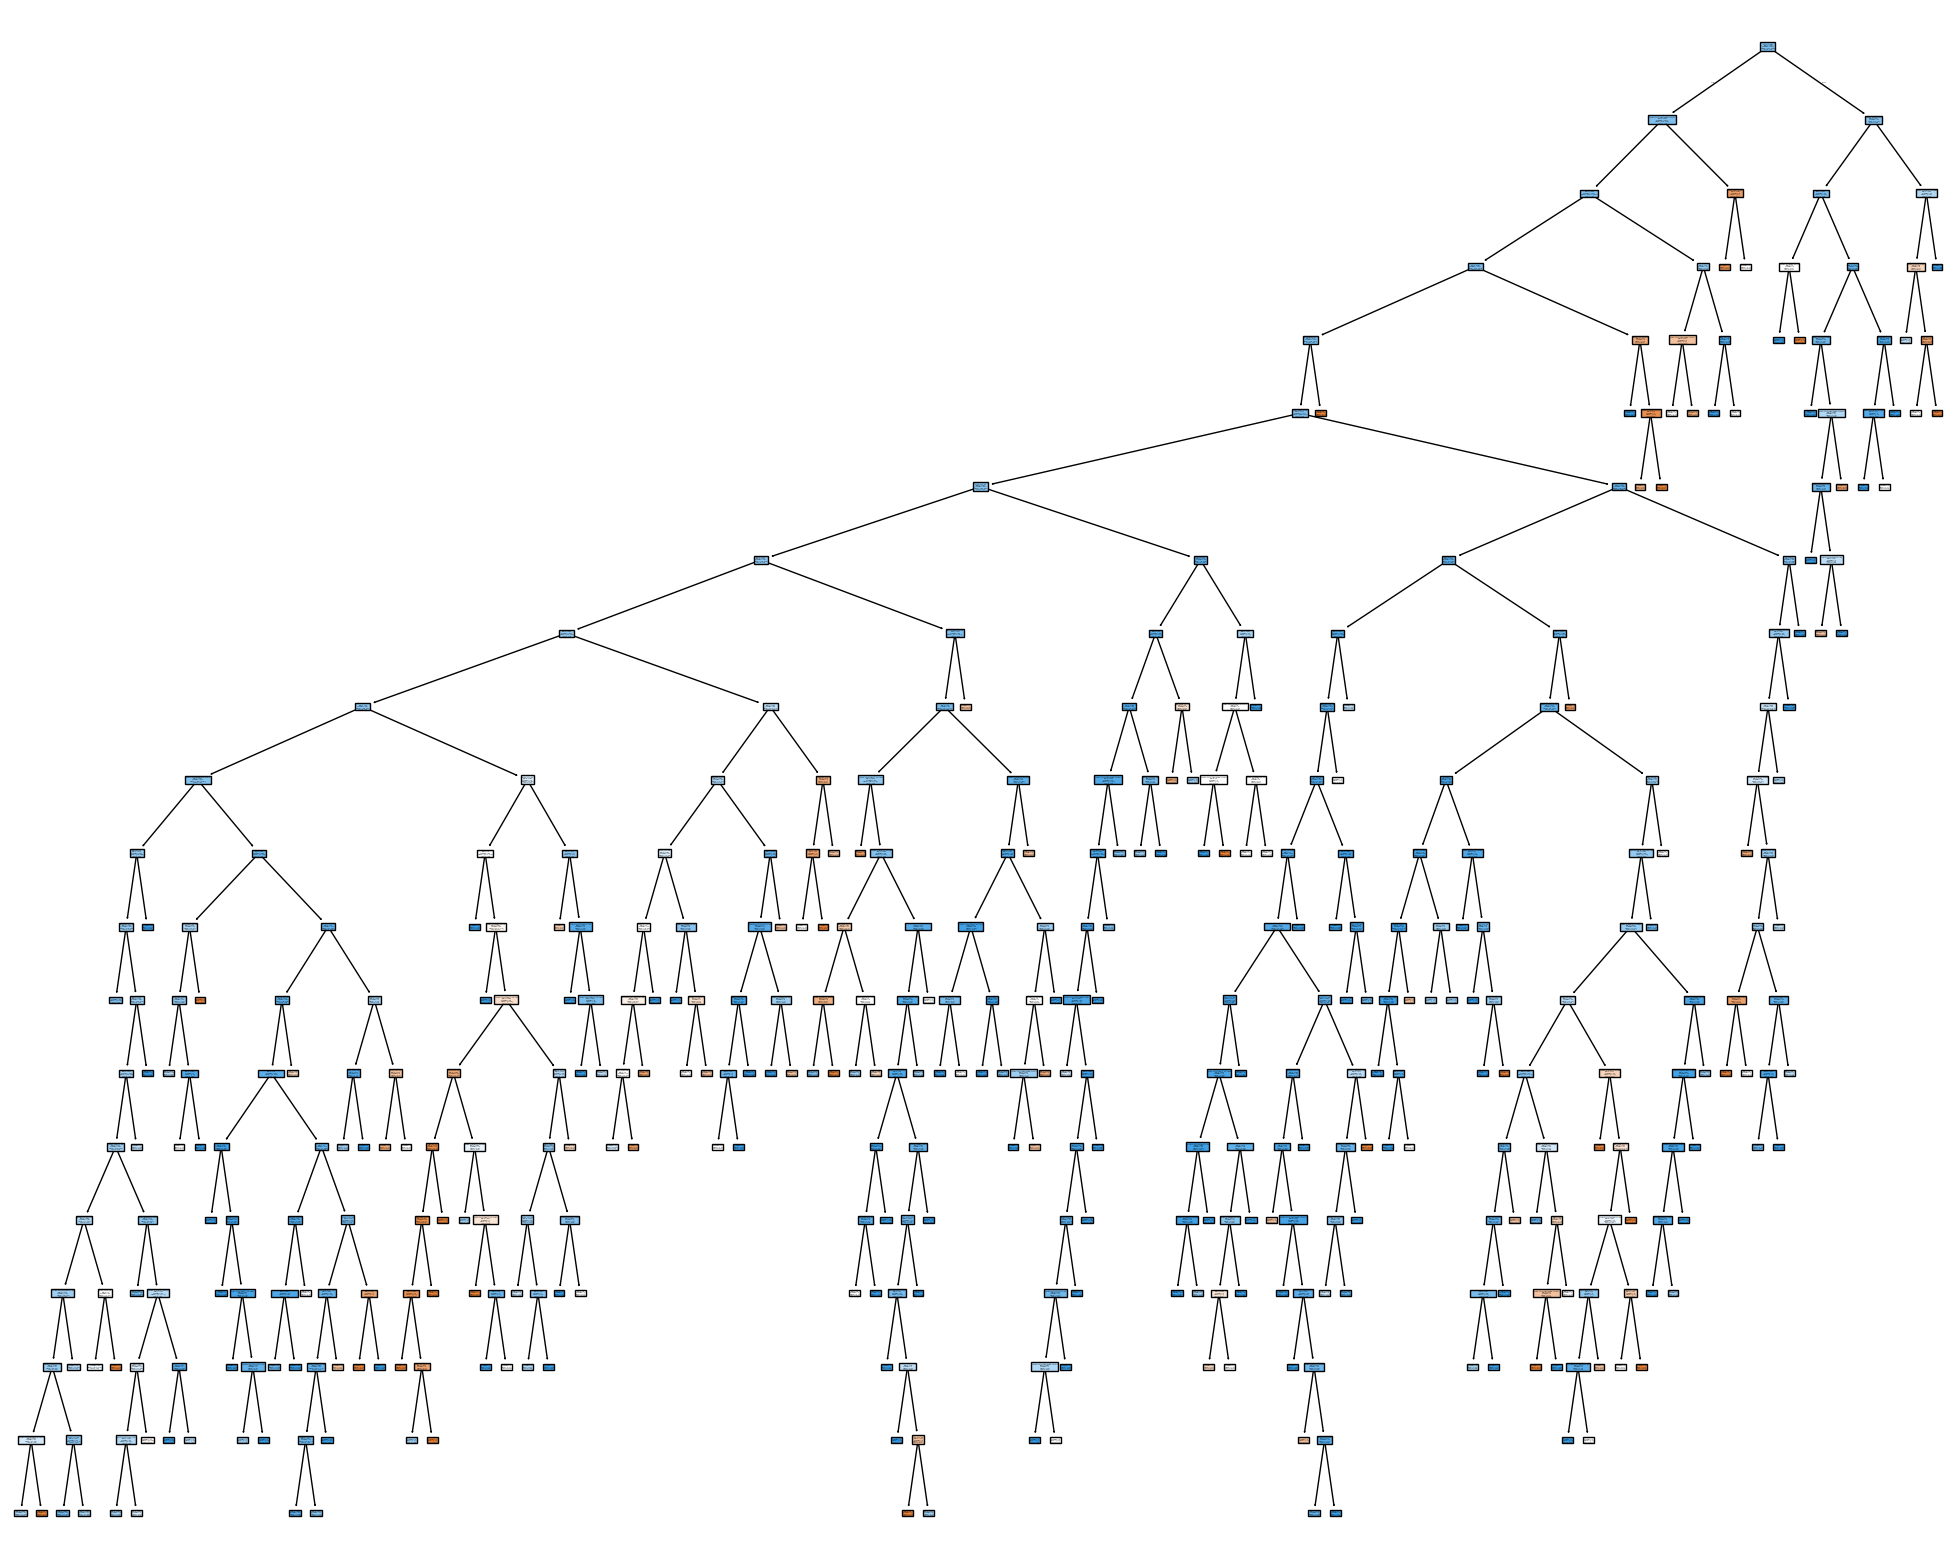

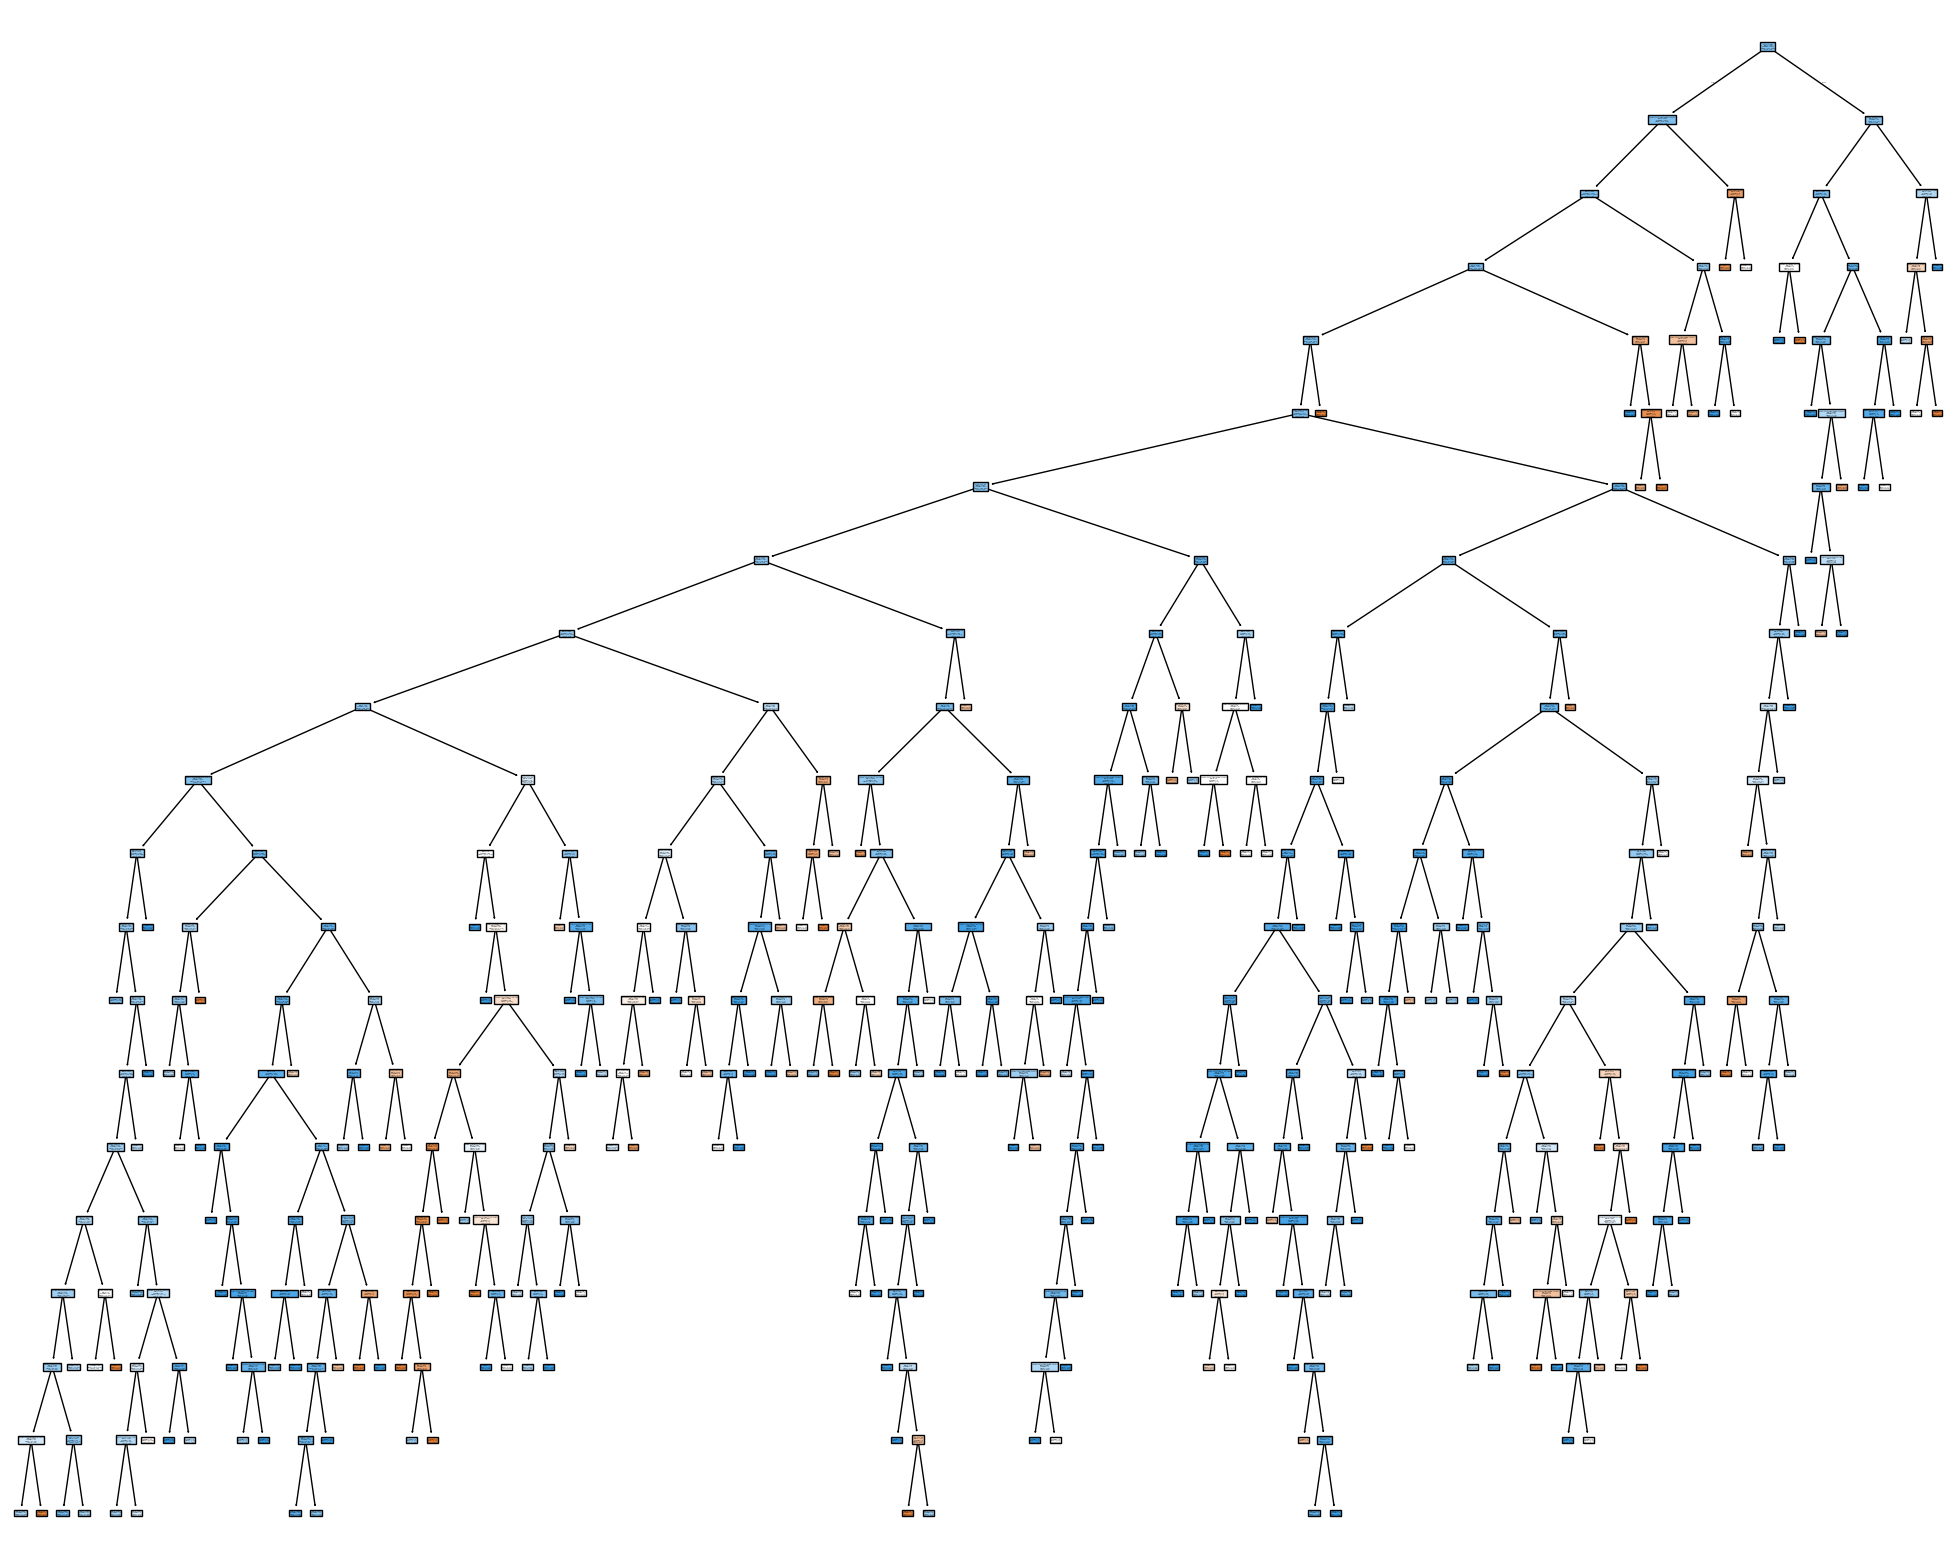

In [42]:
fig = plt.figure(figsize=(25,20))
# tree.export_text(best_estimator[0])
# best_estimator.feature_names_in_
# list(map(str, best_estimator.classes_))
tree.plot_tree(
    best_estimator[0], feature_names=best_estimator.feature_names_in_, class_names=list(map(str, best_estimator.classes_)), filled=True
)

display(fig)

In [43]:
grid_search.best_score_

0.8485740765359828

In [44]:
pd.DataFrame(grid_search.cv_results_)['mean_test_f1'].describe()

count    3750.000000
mean        0.838098
std         0.029674
min         0.510354
25%         0.846806
50%         0.847132
75%         0.847132
max         0.848574
Name: mean_test_f1, dtype: float64

In [45]:
pd.DataFrame(grid_search.cv_results_)['mean_test_precision'].describe()

count    3750.000000
mean        0.735739
std         0.005822
min         0.697456
25%         0.734804
50%         0.734804
75%         0.734804
max         0.840803
Name: mean_test_precision, dtype: float64

In [46]:
pd.DataFrame(grid_search.cv_results_)['mean_test_recall'].describe()

count    3750.000000
mean        0.980879
std         0.055358
min         0.577191
25%         0.998667
50%         1.000000
75%         1.000000
max         1.000000
Name: mean_test_recall, dtype: float64

In [47]:
for failing_method in train_failing_methods:
    print(failing_method)
    X = train_df[train_df[failing_method]].iloc[:, :-1]
    y = train_df[train_df[failing_method]].iloc[:, -1]

    prec = cross_val_score(best_estimator, X, y, cv = 5, scoring = 'precision')
    print(mean(prec))

    rec = cross_val_score(best_estimator, X, y, cv = 5, scoring = 'recall')
    print(mean(rec))
    print()

HIT01_8
0.815
0.9878787878787879

HIT02_24
0.581038961038961
0.8142857142857143

HIT03_6
0.665457419860405
0.9101757631822387

HIT04_7
0.7482274599980837
0.9854873054873055

HIT07_33
0.7295977011494252
0.9160173160173161

HIT08_54
0.7561217948717949
0.9297297297297297



# Prediction

In [48]:
X = holdout_df.iloc[:, :-1]
X

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa
1400,97.788,5,3,3,1,1,3,10.0,27,False,242,0.818182,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1401,54.289,4,2,3,1,1,3,5.0,20,True,106,0.863636,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,Fals

In [49]:
y = holdout_df.iloc[:, -1]
y

1400    True
1401    True
1402    True
1403    True
1404    True
        ... 
1935    True
1936    True
1937    True
1938    True
1939    True
Name: Correct, Length: 540, dtype: bool

In [50]:
best_estimator.predict(X)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [51]:
for failing_method in holdout_failing_methods:
    print(failing_method)
    X = holdout_df[holdout_df[failing_method]].iloc[:, :-1]
    y = holdout_df[holdout_df[failing_method]].iloc[:, -1]

    prec = cross_val_score(best_estimator, X, y, cv = 5, scoring = 'precision')
    print(mean(prec))

    rec = cross_val_score(best_estimator, X, y, cv = 5, scoring = 'recall')
    print(mean(rec))
    print()

HIT05_35
0.598007574553737
0.7913043478260869

HIT06_51
0.7269048515304938
0.9433962264150944



In [52]:
full_df[full_df['Correct']]

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa,Correct
0,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,7.0,21,True,98,0.937500,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,10.0,25,False,67,0.923077,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False

(array([  1.,   0.,   6.,  24.,  48., 104., 194., 318., 352., 827.]),
 array([0.40540541, 0.46486486, 0.52432432, 0.58378378, 0.64324324,
        0.7027027 , 0.76216216, 0.82162162, 0.88108108, 0.94054054,
        1.        ]),
 <BarContainer object of 10 artists>)

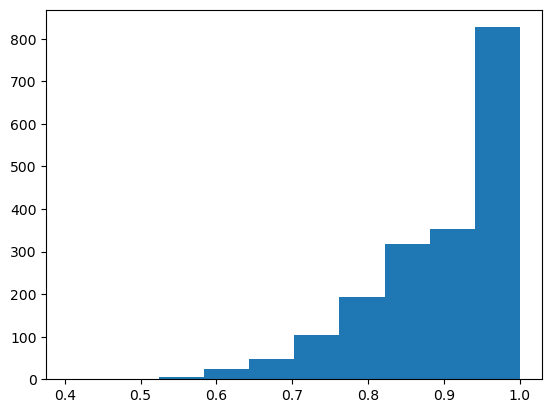

In [53]:
plt.hist(full_df[full_df['Correct']]['Answer.explanation_ttr'])

(array([1.621e+03, 1.980e+02, 4.000e+01, 1.100e+01, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.3920e+02, 4.7740e+02, 7.1560e+02, 9.5380e+02,
        1.1920e+03, 1.4302e+03, 1.6684e+03, 1.9066e+03, 2.1448e+03,
        2.3830e+03]),
 <BarContainer object of 10 artists>)

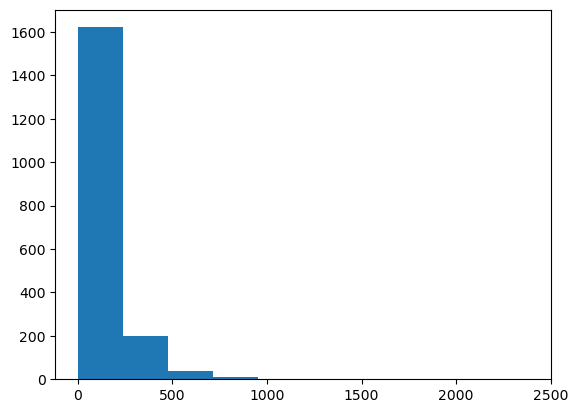

In [54]:
plt.hist(full_df[full_df['Correct']]['Answer.explanation_length'])

# Consolidation

In [55]:
def bleu(seq_0, seq_1):
    seq_0 = seq_0.lower().strip()
    seq_1 = seq_1.lower().strip()

    tokens_0 = seq_0.split()
    tokens_1 = seq_1.split()
    
    num_tokens_0 = len(tokens_0)
    num_tokens_1 = len(tokens_1)
    
    return math.exp(
        min(0, 1 - num_tokens_1 / num_tokens_0)
    ) * math.prod(
        (sum(1 for j in range(num_tokens_0) if tokens_0[j:j + i] in tokens_1) / (num_tokens_0 - i + 1)) ** (1 / (2 ** i))
        for i in range(1, num_tokens_0 + 1)
    )

In [56]:
def rouge(seq_0, seqs_1):
    seq_0 = seq_0.lower().strip()
    seqs_1_it = map(lambda seq: seq.lower().strip(), seqs_1)

    tokens_0 = seq_0.split()
    tokens_1_it = list(map(lambda seq: seq.split(), seqs_1_it))
    
    num_tokens_0 = len(tokens_0)
    num_tokens_1_it = list(map(lambda tokens: len(tokens), tokens_1_it))
    
    return sum(
        sum(
            sum(1 for j in range(num_tokens_0) if tokens_0[j:j + i] in tokens_1) for i in range(1, num_tokens_0 + 1)
        ) for tokens_1 in tokens_1_it
    ) / sum(sum(num_tokens_1 - i + 1 for i in range(1, num_tokens_1 + 1)) for num_tokens_1 in num_tokens_1_it)

In [57]:
correct_examples = full_df[full_df['Correct']]
correct_examples

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.order,Answer.explanation,Code.LOC,Code.complexity,Worker.score,Worker.yearsOfExperience,Worker.age,Male,Answer.explanation_length,Answer.explanation_ttr,Other work,Other self-taught,Other professional,High school,Other diploma,Other elementary school,Other had a book on basic when i was a kid,Other self taught,Other when i started programming (at age 9),Other,Other first robotics,Other private institute,Web,Other through work,Other at work,Other professionally,Other middle school,Other taught myself the basics as a kid,Other mooc,Other summer camp,Other leanred more experts at work,Other self study,Other self-study,Other na,Other junior high computer class,Other training classes,Other java while on the job,Other by myself from books,No?,Other found a book,"There was no ""internet"". i had a trs-80 for gosh sake. we learned from books! made of paper. odd concept",Other as long as i can remember honestly,Other self help books,University,Other employer,Other books,Other self-taught as a child,Other forever,Other us army,Other instructional books,Books,Other on the job,Other i really dont remember a time when i couldnt,Other autodidact,Other hobby,Other hobbyist,Other private,,Matlab,Vbs,Elixir,Visual basic,Rpg,Visual foxpro,Sql,Javascript,Swift,C#,Most c and ksh in past,Go,Js,Pl/sql,Jav,Dot net and core java,Developing,Euphoria,None at present,C# vb.net java,5,Vb.net,Php,C/c++,Ahk,Vba,C,Java,Html/css (formerly c# and java in previous jobs),Html,Ajax,Scheme,Ruby,Java c++,Tera data,C++ and python,.net,Css3,R,Html5,Php and c++,Assembly,C++,Asp.net,Sql (teradata/ms-sql),C sharp,Vb .net java,3,Python,Ruby & javascript,Css,Various,Perl,Magic,Mysql,Sas,Autoit,Jsp,Asp,Vhdl,Mql4,Cuda,C+,Visual fox pro,Jee,Scala,Ruby on rails,Ada,Plsql,Nan,Visualbasic,6,Php/javascript,C/c++ and some python and java,A little bit of java,Vbscript,Bash and powershell,Basic,Object pascal,Java python,Bash,None,Peoplesoft,Groovy,Xml,Do not currently use,HIT01_8,HIT02_24,HIT03_6,HIT04_7,HIT05_35,HIT06_51,HIT07_33,HIT08_54,Graduate_Student,Hobbyist,Other profession,Professional_Developer,Undergraduate_Student,Brazil,Bulgaria,Canada,Colombia,Croatia,Germany,INDIA,India,Italy,Latvia,New Zealand,PHILIPPINES,Poland,Romania,Russia,Serbia,Sri Lanka,U.S,U.S.,U.S.A.,US,USA,United States,United States of America,United states,Unites States of America,Usa,canada,india,indian,madurai,uk,united States,united states,us,usa,Correct
0,90.984,4,2,3,hoursOffset accepts negative numbers between -...,1,1,5,7.0,21,True,98,0.937500,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,133.711,5,1,3,the conditional clause is correct for the give...,1,1,4,10.0,25,False,67,0.923077,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False

In [58]:
chat_gpt_0 = '''Program Functionality
The program processes time offsets using a function that takes minutesOffset as an argument. Specifically, the function DateTimeZone.forOffsetHoursMinutes(-2, -15) assigns the value -15 to minutesOffset. This value is used in a check to validate the time offset, ensuring it falls within an acceptable range.

Failure Mechanism
The failure occurs because the code allows minutesOffset to be assigned a negative value. When minutesOffset is less than 0 (e.g., -15), the program throws an illegal argument exception. This happens because the logic checks do not properly restrict values of minutesOffset to the expected range between 0 and 59 or -59 and 0.

Code Issue
The root issue lies in incomplete or incorrect conditional checks for minutesOffset. Specifically:

The code neglects to enforce bounds for the minutesOffset variable.
While comments suggest the variable should be an "unsigned int," its actual behavior allows negative values, which causes exceptions.
The problematic condition appears on line 279, where an invalid range for minutesOffset is not properly handled.'''

In [59]:
chat_gpt_1 = '''The bug stems from the variable g, which is computed using the value parameter. The calculation allows g to take on negative values when value is outside the range defined by this.lowerBound and this.upperBound. This causes the Color constructor to throw an IllegalArgumentException, as the valid range for g in the Color constructor is 0 to 255.

Although the code attempts to enforce bounds through variables like v, the issue arises because v is not used in the calculation of g. Instead, the unsanitized value is used. To fix this, v—which is properly constrained to the bounds—should replace value in the computation of g.

Additionally:

The value parameter is of type double, which is consistent with other parts of the code and unrelated to the error.
The calculation of g depends on the correctness of this.lowerBound and this.upperBound, which are not provided but must be verified to ensure they correctly bound the input range.
To resolve the bug, ensure that v (a sanitized version of value) is used in place of value when calculating g.'''

In [60]:
chat_gpt_2 = '''The bug arises because the pos variable is incremented by the character count returned by Character.charCount() in conjunction with Character.codePointAt(), which may result in pos exceeding the length of the input string (len). This happens because surrogate pairs in Unicode can require more than one char to represent a single character. If pos is incremented beyond len without proper validation, attempting to access an index outside the bounds of the string triggers a StringIndexOutOfBoundsException. To fix this, add a check to ensure pos remains within bounds before processing further or incrementing.'''

In [61]:
chat_gpt_3 = '''The issue lies in the incorrect use of this.minMiddleIndex instead of this.maxMiddleIndex in the method responsible for updating bounds. Specifically, the calculation for s and e incorrectly references this.minMiddleIndex, which leads to an inaccurate calculation of maxMiddleIndex. Updating these lines to use this.maxMiddleIndex resolves the problem, as it ensures the correct index is used for retrieving time period values.'''

In [62]:
chat_gpt_4 = '''Explanation of the Bug
The issue arises in a generic method that copies an array and appends an element to it. If both the input array and the element are null, the code sets the type of the resulting array to Object.class. This leads to the creation of an Object[] array when the copyArrayGrow1 method is called. However, the code attempts to cast this Object[] array to a generic type T[]. If T is inferred to be String or another specific type, this results in a ClassCastException because Java does not allow casting an Object[] to String[] (or other specific types).

Root Cause
The line Class<?> type = array != null ? array.getClass() : (element != null ? element.getClass() : Object.class); determines the type of the array to be created. When both array and element are null, type defaults to Object.class.
This type is then used in copyArrayGrow1 to create a new array of type Object[].
The method subsequently casts the Object[] to T[], which is invalid when T is a specific type such as String.
Fix
To fix the issue, you need to handle the case where both array and element are null more explicitly. Instead of defaulting to Object.class, throw an exception. Here's a suggested fix:

java
Copy code
Class<?> type;
if (array != null) {
    type = array.getClass().getComponentType(); // Use the type of the input array
} else if (element != null) {
    type = element.getClass(); // Use the type of the element
} else {
    throw new IllegalArgumentException("Both array and element cannot be null.");
}
This ensures that the method fails gracefully when invalid input is provided, rather than defaulting to an incompatible type.

By addressing the root cause and introducing explicit error handling, this fix prevents the ClassCastException and makes the behavior of the method more predictable'''

In [63]:
chat_gpt_5 = '''The bug stems from how the code handles the conversion and comparison of `-0.0` and `0.0`. The core issue lies in the implicit type conversions during mathematical operations and string formatting, particularly the treatment of `long` values when converting from floating-point numbers. Specifically:

1. **Type Conversion**: Casting a `double` (`x`) to a `long` causes the decimal component to be discarded, resulting in `0` for both `0.0` and `-0.0`.
2. **Comparison Logic**: The comparison `(long)x == x` may fail for specific edge cases due to type mismatches or the nuances of floating-point and integer representations in Java.
3. **String Conversion**: The use of `Long.toString(value)` strips the `-0` information because a `long` type does not preserve the sign of zero.
4. **Test Method**: The `parsePrint` or related test method that processes the output is not included, making it challenging to trace the exact cause of the failure without that context.

**Possible Root Causes**:
- The failure occurs when handling `-0.0` during string conversion, where `-0.0` is expected, but `0` is returned due to the `long` conversion.
- The loop logic or related conditional checks may inadvertently exclude edge cases, preventing correct formatting or causing infinite loops.
- A mismatch in formatting expectations for `-0.0` and `0.0` exists in the test or the code being evaluated.

**Resolution**:
- **Preserve Floating-Point Representation**: Avoid casting `double` to `long` when the sign of zero is critical. Use `Double.toString(x)` or similar methods to retain precision and sign information.
- **Test Edge Cases Explicitly**: Ensure the test cases include scenarios for `-0.0`, `0.0`, and other edge values to validate formatting and behavior.
- **Update Logic**: Adjust conditionals or parsing methods to handle `-0.0` explicitly, ensuring that expected output matches the actual processing.
- **Clarify Dependencies**: Include the `parsePrint` method or any other relevant context to trace how the output is being processed or validated.
'''

In [64]:
chat_gpt_6 = '''### Assessment and Consolidation of Explanation

Based on the 60 explanations, the recurring themes and the most helpful observations can be synthesized into the following detailed explanation:

---

The NullPointerException (NPE) occurs because the code attempts to dereference a `null` element within the input array. Specifically:

1. **Function Context**:
   - The function `toClass(Object... array)` is designed to convert an array of objects into an array of `Class` objects. If any element in the input array is `null`, a `null` is inserted in the resulting `Class[]`. However, the process must handle such `null` values gracefully.

2. **Critical Code Segment**:
   - In the loop (starting around line 910), the code iterates through the input `array` and calls `array[i].getClass()` for each element. If `array[i]` is `null`, invoking `getClass()` results in an NPE because `null` has no class.

3. **Triggering Condition**:
   - The exception is triggered when the second element of the input array (`array[1]`) is `null`. The specific input passed to the method is:
     ```java
     new Object[]{"Test", null, 99d};
     ```
     Here, `array[1]` is `null`, leading to the NPE at the `getClass()` call.

4. **Problem with the Current Implementation**:
   - The loop does not include a `null` check for each element before attempting to dereference it. Without this safeguard, the code does not handle cases where the input array contains `null` values.

5. **Proposed Fix**:
   - Introduce a `null` check before dereferencing the array elements. Modify the loop as follows:
     ```java
     for (int i = 0; i < array.length; i++) {
         classes[i] = (array[i] == null) ? null : array[i].getClass();
     }
     ```
     This ensures that `classes[i]` is assigned `null` if `array[i]` is `null`, avoiding the NPE.

6. **Documentation of Behavior**:
   - The `toClass` method must explicitly state in its documentation that if `null` elements are present in the input array, they will result in `null` elements in the output `Class[]`.

7. **Additional Notes**:
   - If the calling code or the library expects no `null` values, validate the input array at the beginning of the method and throw a more informative exception, such as:
     ```java
     if (array == null || Arrays.stream(array).anyMatch(Objects::isNull)) {
         throw new IllegalArgumentException("Input array must not contain null values.");
     }
     ```

---

This consolidated explanation identifies the root cause, clarifies the conditions leading to the error, and provides actionable fixes while ensuring proper understanding of the code's behavior and best practices for handling such issues.'''

In [65]:
chat_gpt_7 = '''The issue arises because the input format is incorrect. The expected format is cc__CCCCC, where c is lowercase, and C is uppercase. The input fr__POSIX fails the validation because the third character, which should be a lowercase letter, is an underscore (_). In the code, lines 115-117 check if characters at specific positions are uppercase letters. Since the third character is an underscore, it fails the condition ch3 > 'A' || ch3 < 'Z', triggering an IllegalArgumentException. This exception is thrown as expected, as underscores are not valid for the locale format.'''

In [66]:
for chat_gpt, failing_method in zip(
    (chat_gpt_0, chat_gpt_1, chat_gpt_2, chat_gpt_3, chat_gpt_4, chat_gpt_5, chat_gpt_6, chat_gpt_7),
    ('HIT01_8', 'HIT02_24', 'HIT03_6', 'HIT04_7', 'HIT05_35', 'HIT06_51', 'HIT07_33')
):
    print(failing_method)
    print(mean(bleu(chat_gpt, str(seq)) for seq in correct_examples[correct_examples[failing_method]]['Answer.explanation']))
    print(rouge(chat_gpt, list(map(str, correct_examples[correct_examples[failing_method]]['Answer.explanation']))))

HIT01_8
0.0
0.0
HIT02_24
0.0
0.0
HIT03_6
0.0
0.0
HIT04_7
0.0
0.0
HIT05_35
0.0
0.0
HIT06_51
0.0
0.0
HIT07_33
0.0
0.0


In [67]:
correct_examples[correct_examples['HIT04_7']]['Answer.explanation']

660     the "period" variable is used to set the start...
661     I don't think there's anything wrong with line...
662     No; the TimePeriod period does not seem to be ...
663                               Incomplete source code.
664     Cannot see any issue with the use of the varia...
                              ...                        
1394    This conditional looks like it will function c...
1396                                       Seems correct.
1397    no error on a simple if statement comparing 2 ...
1398    The conditional appears to be functioning as i...
1399    I do not think that is what is causing the pro...
Name: Answer.explanation, Length: 553, dtype: object